<a href="https://colab.research.google.com/github/gmadaan15/ML_on_mnist/blob/main/ML_on_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

This project/notebook implements from very basic ML algorithms to advanced neural nets. Its also a mix of two out of the five projects that I did in the EDX MIT MOOC( link text). Most of the helper functions and the basic structure were given in the base project. The idea behind converting this to a notebook was to make it more organised, readable and runnable off the shelf, and to add the support of gpus so that the neural net based models work faster. In addition to trying on the Mnist digit dataset, we also tried the neural net based models on an extra fashion based dataset for binary classification. This explores the nn's performance when augmentations are done and when augmentations are not done.

One more reason behind making this notebook was to present the ML related helper functions more explicitly in one runnable format.

Make sure that the 'Datasets' folder is there, if not try accessing using my drive link: [Datasets](https://drive.google.com/drive/folders/1VVqQYumByJ8iSuJ5G-rz4epEu-IQWDLH?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/Datasets ./

# READING DATASET HELPER FUNCTIONS

In [ ]:
import pickle, gzip, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math


def plot_images(X):
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()


def pick_examples_of(X, Y, labels, total_count):
    bool_arr = None
    for label in labels:
        bool_arr_for_label = (Y == label)
        if bool_arr is None:
            bool_arr = bool_arr_for_label
        else:
            bool_arr |= bool_arr_for_label
    filtered_x = X[bool_arr]
    filtered_y = Y[bool_arr]
    return (filtered_x[:total_count], filtered_y[:total_count])


def extract_training_and_test_examples_with_labels(train_x, train_y, test_x, test_y, labels, training_count, test_count):
    filtered_train_x, filtered_train_y = pick_examples_of(train_x, train_y, labels, training_count)
    filtered_test_x, filtered_test_y = pick_examples_of(test_x, test_y, labels, test_count)
    return (filtered_train_x, filtered_train_y, filtered_test_x, filtered_test_y)

def write_pickle_data(data, file_name):
    f = gzip.open(file_name, 'wb')
    pickle.dump(data, f)
    f.close()

def read_pickle_data(file_name):
    f = gzip.open(file_name, 'rb')
    data = pickle.load(f, encoding='latin1')
    f.close()
    return data

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('./Datasets/mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

def load_train_and_test_pickle(file_name):
    train_x, train_y, test_x, test_y = read_pickle_data(file_name)
    return train_x, train_y, test_x, test_y

# returns the feature set in a numpy ndarray
def load_CSV(filename):
    stuff = np.asarray(np.loadtxt(open(filename, 'rb'), delimiter=','))
    return stuff


# LINEAR REGRESSION(the closed form one)

In [ ]:
import numpy as np

def closed_form(X, Y, lambda_factor):
    """
    Computes the closed form solution of linear regression with L2 regularization

    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    a = X.T @ X
    b = lambda_factor * np.identity(X.shape[1])
    c = X.T @ Y
    d = np.linalg.inv(a + b)
    return d @ c

def compute_test_error_linear(test_x, Y, theta):
    test_y_predict = np.round(np.dot(test_x, theta))
    test_y_predict[test_y_predict < 0] = 0
    test_y_predict[test_y_predict > 9] = 9
    return 1 - np.mean(test_y_predict == Y)

# SVM(Multiclass and One vs all, from sklearn)

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC

def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    clf = LinearSVC(C=0.1, random_state=0).fit(train_x, train_y)
    # decision_function = clf.decision_function(test_x)
    pred_test_y = clf.predict(test_x)
    return pred_test_y


def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = LinearSVC(C=0.1, random_state=0).fit(train_x, train_y)
    # decision_function = clf.decision_function(test_x)
    pred_test_y = clf.predict(test_x)
    return pred_test_y


def compute_test_error_svm(test_y, pred_test_y):
    return 1 - np.mean(pred_test_y == test_y)



# Multinomial (Softmax) Regression and Gradient Descent
It has a variation on the output as well, instead of outputting y, the output of y%3 is tried and separate function definitions are written.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse


def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].

    Args:
        X - a NumPy matrix of n data points, each with d - 1 features

    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    theta_trans_X = theta @ X.T
    theta_trans_X = theta_trans_X / temp_parameter
    c_vec = np.amax(theta_trans_X, axis=0)

    for col_idx in range(theta_trans_X.shape[1]):
        theta_trans_X.T[col_idx] -= c_vec[col_idx]

    theta_trans_X = np.exp(theta_trans_X)
    sum_vec = np.sum(theta_trans_X, axis=0)
    for col_idx in range(theta_trans_X.shape[1]):
        theta_trans_X.T[col_idx] /= sum_vec[col_idx]

    return theta_trans_X


def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    probs = compute_probabilities(X, theta, temp_parameter)
    score = np.log(probs)
    score = np.nan_to_num(score, posinf=0, neginf=0)
    y_modified = np.zeros(probs.shape)
    for j in range(probs.shape[1]):
        for i in range(probs.shape[0]):
            y_modified[i][j] = 1.0 if Y[j] == i else 0.0
    first = y_modified * score
    first = -np.sum(first) / probs.shape[1]

    second = theta ** 2
    second = np.sum(second)
    second = lambda_factor / 2.0 * second
    return first + second

def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    probs = compute_probabilities(X, theta, temp_parameter)
    n = probs.shape[1]
    k = probs.shape[0]
    y_modified = sparse.coo_matrix(([1] * n, (Y, range(n))), shape=(k, n)).toarray()

    M = y_modified - probs
    M = M @ X
    first = -M / temp_parameter / n
    second = lambda_factor * theta
    delta = first + second
    new_theta = theta - delta * alpha

    return new_theta

def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    return train_y % 3, test_y % 3

def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    assigned_labels = get_classification(X, theta, temp_parameter)
    assigned_labels = assigned_labels % 3
    return 1 - np.mean(assigned_labels == Y)

def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()

def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)


# Driver Code(for running the above models)

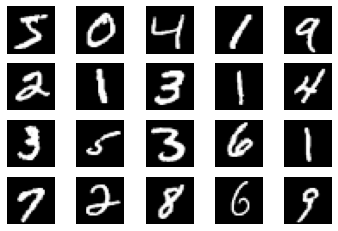

Linear Regression test_error = 0.7697
SVM one vs. rest test_error: 0.007499999999999951
Multiclass SVM test_error: 0.08189999999999997


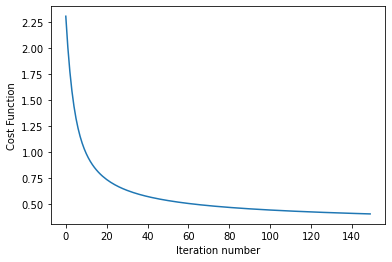

softmax test_error= 0.10050000000000003


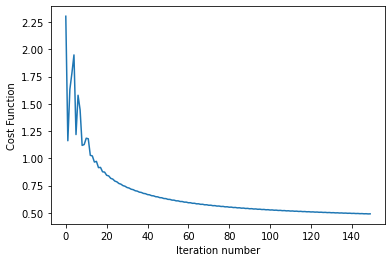

softmax test_error with changed labels = 0.18720000000000003


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt


#######################################################################
# 1. Introduction
#######################################################################

# Load MNIST data:
train_x, train_y, test_x, test_y = get_MNIST_data()
# Plot the first 20 images of the training set.
plot_images(train_x[0:20, :])

#######################################################################
# 2. Linear Regression with Closed Form Solution
#######################################################################

# TODO: first fill out functions in linear_regression.py, otherwise the functions below will not work


def run_linear_regression_on_MNIST(lambda_factor=1):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    return test_error

print('Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=1))


#######################################################################
# 3. Support Vector Machine
#######################################################################

# TODO: first fill out functions in svm.py, or the functions below will not work

def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('SVM one vs. rest test_error:', run_svm_one_vs_rest_on_MNIST())


def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('Multiclass SVM test_error:', run_multiclass_svm_on_MNIST())

#######################################################################
# 4. Multinomial (Softmax) Regression and Gradient Descent
#######################################################################
def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")
    return test_error


print('Softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))


#######################################################################
# 6. Changing Labels
#######################################################################
def run_softmax_on_MNIST_mod3(temp_parameter=1):
    """
    Trains Softmax regression on digit (mod 3) classifications.

    See run_softmax_on_MNIST for more info.
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y, test_y = update_y(train_y, test_y)
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4,
                                                      k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")
    return test_error

print('Softmax test_error with changed labels =', run_softmax_on_MNIST_mod3(temp_parameter=1))


# NEURAL NETWORKS

Helper functions for training, validating and testing NNs

In [ ]:
import cv2
import glob
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import sys

In [ ]:
# flatten the array nn module
class Flatten(nn.Module):
    """A custom layer that views an input as 1D."""

    def forward(self, input):
        return input.view(input.size(0), -1)

# Helpers
#Takes a set of data points and labels and groups them into batches.
# also does the special task of converting arrays from np to torch on the available device
def batchify_data(x_data, y_data, batch_size, device):
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype=torch.float32, device = device),
            'y': torch.tensor(y_data[i:i+batch_size], dtype=torch.long, device = device
        )})
    return batches
# split data into test and validation
def split_data(X_train, y_train):
    dev_split_index = int(9 * len(X_train) / 10)
    X_dev = X_train[dev_split_index:]
    y_dev = y_train[dev_split_index:]
    X_train = X_train[:dev_split_index]
    y_train = y_train[:dev_split_index]

    return X_train, y_train, X_dev, y_dev

# randomise the data
def randomise_data(X_train, y_train):
    permutation = np.array([i for i in range(len(X_train))])
    np.random.shuffle(permutation)
    X_train = [X_train[i] for i in permutation]
    y_train = [y_train[i] for i in permutation]
    return X_train, y_train

# compute the accuracy against the targets
def compute_accuracy(predictions, y):
    return torch.mean(torch.eq(predictions, y).double())
    #return np.mean(np.equal(predictions.numpy(), y.numpy()))


# Training Procedure
# Train a model for N epochs given data and hyper-params
def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov=False, n_epochs=30):
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

    for epoch in range(1, n_epochs+1):
        print("-------------\nEpoch {}:\n".format(epoch))


        # Run training
        loss, acc = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))

        # Run validation NOTE the ".eval" mode below
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))

        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return val_acc

# Train model for one pass of train data, and return loss, acccuracy
def run_epoch(data, model, optimizer):
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        out = model(x)
        #print("out : {}".format(out))

        # Predict and store accuracy
        #print(out)
        predictions = torch.argmax(out, dim=1)
        #print("predictions : {}".format(predictions))
        batch_accuracies.append(compute_accuracy(predictions, y).data.item())

        # Compute loss
        loss = F.cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy



Check for availability of GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Multilayer Perceptron model(need data to be flatten)

In [ ]:
num_classes = 10
hidden_layer = 2**14
mlp_model = nn.Sequential(
              nn.Linear(28*28, hidden_layer),
              nn.ReLU(),
              nn.Linear(hidden_layer, num_classes),
            )
mlp_model = mlp_model.to(device)

Testing the MLP on MNIST

In [ ]:
X_train, y_train, X_test, y_test = get_MNIST_data()

# We need to rehape the data back into a flat vector
X_train = np.reshape(X_train, (X_train.shape[0], 28*28)) 
X_test = np.reshape(X_test, (X_test.shape[0], 28*28))

X_train, y_train = randomise_data(X_train, y_train)

X_train, y_train, X_dev, y_dev = split_data(X_train, y_train)

# Split dataset into batches
batch_size = 32
train_batches = batchify_data(X_train, y_train, batch_size, device)
dev_batches = batchify_data(X_dev, y_dev, batch_size, device)
test_batches = batchify_data(X_test, y_test, batch_size, device)


train_model(train_batches, dev_batches, mlp_model, nesterov=False, n_epochs = 11, lr=0.001)

## Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, mlp_model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


-------------
Epoch 1:



100%|██████████| 1687/1687 [00:08<00:00, 199.57it/s]


Train loss: 0.526968 | Train accuracy: 0.872314


100%|██████████| 187/187 [00:00<00:00, 1756.19it/s]


Val loss:   0.339658 | Val accuracy:   0.904579
-------------
Epoch 2:



100%|██████████| 1687/1687 [00:06<00:00, 276.10it/s]


Train loss: 0.298530 | Train accuracy: 0.918272


100%|██████████| 187/187 [00:00<00:00, 1709.19it/s]


Val loss:   0.282294 | Val accuracy:   0.918616
-------------
Epoch 3:



100%|██████████| 1687/1687 [00:06<00:00, 276.97it/s]


Train loss: 0.255741 | Train accuracy: 0.928886


100%|██████████| 187/187 [00:00<00:00, 1678.03it/s]


Val loss:   0.251658 | Val accuracy:   0.928810
-------------
Epoch 4:



100%|██████████| 1687/1687 [00:06<00:00, 277.80it/s]


Train loss: 0.228373 | Train accuracy: 0.936926


100%|██████████| 187/187 [00:00<00:00, 1757.64it/s]


Val loss:   0.229617 | Val accuracy:   0.934659
-------------
Epoch 5:



100%|██████████| 1687/1687 [00:06<00:00, 277.00it/s]


Train loss: 0.207279 | Train accuracy: 0.942928


100%|██████████| 187/187 [00:00<00:00, 1700.62it/s]


Val loss:   0.212094 | Val accuracy:   0.939338
-------------
Epoch 6:



100%|██████████| 1687/1687 [00:06<00:00, 278.18it/s]


Train loss: 0.189878 | Train accuracy: 0.947855


100%|██████████| 187/187 [00:00<00:00, 1716.87it/s]


Val loss:   0.197571 | Val accuracy:   0.943349
-------------
Epoch 7:



100%|██████████| 1687/1687 [00:06<00:00, 256.78it/s]


Train loss: 0.175065 | Train accuracy: 0.952227


100%|██████████| 187/187 [00:00<00:00, 1800.77it/s]


Val loss:   0.185270 | Val accuracy:   0.946190
-------------
Epoch 8:



100%|██████████| 1687/1687 [00:06<00:00, 277.14it/s]


Train loss: 0.162253 | Train accuracy: 0.956061


100%|██████████| 187/187 [00:00<00:00, 1744.23it/s]


Val loss:   0.174734 | Val accuracy:   0.948362
-------------
Epoch 9:



100%|██████████| 1687/1687 [00:06<00:00, 277.47it/s]


Train loss: 0.151065 | Train accuracy: 0.959599


100%|██████████| 187/187 [00:00<00:00, 1695.61it/s]


Val loss:   0.165627 | Val accuracy:   0.951203
-------------
Epoch 10:



100%|██████████| 1687/1687 [00:06<00:00, 273.55it/s]


Train loss: 0.141218 | Train accuracy: 0.962582


100%|██████████| 187/187 [00:00<00:00, 1332.04it/s]


Val loss:   0.157702 | Val accuracy:   0.953710
-------------
Epoch 11:



100%|██████████| 1687/1687 [00:06<00:00, 275.10it/s]


Train loss: 0.132486 | Train accuracy: 0.964878


100%|██████████| 187/187 [00:00<00:00, 1728.27it/s]


Val loss:   0.150757 | Val accuracy:   0.957052


100%|██████████| 312/312 [00:00<00:00, 1814.29it/s]

Loss on test set:0.1389499643820529 Accuracy on test set: 0.9600360576923077


## Convolution based neural network

In [ ]:
# note: dimensions can be figured out while running and solving errors
conv_model = nn.Sequential(
          nn.Conv2d(1, 32, (3, 3)),
              nn.ReLU(),
              nn.MaxPool2d((2, 2)),
              nn.Conv2d(32, 64, (3,3)),
              nn.ReLU(),
              nn.MaxPool2d((2, 2)),
              nn.Flatten(),
              nn.Linear(1600, 128),
              nn.Dropout(p=0.5),
              nn.Linear(128, 10),
        )
conv_model = conv_model.to(device)

Testing the Convolution based NN on MNIST

In [ ]:
X_train, y_train, X_test, y_test = get_MNIST_data()

# We need to rehape the data back into a 1x64x64 image
X_train = np.reshape(X_train, (X_train.shape[0], 1, 28,28))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 28,28))

X_train, y_train = randomise_data(X_train, y_train)

X_train, y_train, X_dev, y_dev = split_data(X_train, y_train)

# Split dataset into batches
batch_size = 32
train_batches = batchify_data(X_train, y_train, batch_size, device)
dev_batches = batchify_data(X_dev, y_dev, batch_size, device)
test_batches = batchify_data(X_test, y_test, batch_size, device)


train_model(train_batches, dev_batches, conv_model, nesterov=False, n_epochs = 11, lr=0.001)

## Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, conv_model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 1687/1687 [00:04<00:00, 407.04it/s]


Train loss: 0.825003 | Train accuracy: 0.752649


100%|██████████| 187/187 [00:00<00:00, 1231.27it/s]


Val loss:   0.267439 | Val accuracy:   0.923964
-------------
Epoch 2:



100%|██████████| 1687/1687 [00:03<00:00, 470.41it/s]


Train loss: 0.228128 | Train accuracy: 0.932147


100%|██████████| 187/187 [00:00<00:00, 1244.95it/s]


Val loss:   0.158438 | Val accuracy:   0.954044
-------------
Epoch 3:



100%|██████████| 1687/1687 [00:03<00:00, 471.91it/s]


Train loss: 0.151032 | Train accuracy: 0.955598


100%|██████████| 187/187 [00:00<00:00, 1300.71it/s]


Val loss:   0.116854 | Val accuracy:   0.966076
-------------
Epoch 4:



100%|██████████| 1687/1687 [00:03<00:00, 471.39it/s]


Train loss: 0.123202 | Train accuracy: 0.962711


100%|██████████| 187/187 [00:00<00:00, 1272.36it/s]


Val loss:   0.100556 | Val accuracy:   0.970922
-------------
Epoch 5:



100%|██████████| 1687/1687 [00:03<00:00, 461.63it/s]


Train loss: 0.105187 | Train accuracy: 0.968713


100%|██████████| 187/187 [00:00<00:00, 1282.67it/s]


Val loss:   0.083784 | Val accuracy:   0.974098
-------------
Epoch 6:



100%|██████████| 1687/1687 [00:03<00:00, 473.27it/s]


Train loss: 0.094324 | Train accuracy: 0.971103


100%|██████████| 187/187 [00:00<00:00, 1226.89it/s]


Val loss:   0.076914 | Val accuracy:   0.976939
-------------
Epoch 7:



100%|██████████| 1687/1687 [00:03<00:00, 468.67it/s]


Train loss: 0.085276 | Train accuracy: 0.974159


100%|██████████| 187/187 [00:00<00:00, 1192.61it/s]


Val loss:   0.071855 | Val accuracy:   0.977941
-------------
Epoch 8:



100%|██████████| 1687/1687 [00:03<00:00, 471.41it/s]


Train loss: 0.078955 | Train accuracy: 0.976345


100%|██████████| 187/187 [00:00<00:00, 1216.95it/s]


Val loss:   0.066661 | Val accuracy:   0.980114
-------------
Epoch 9:



100%|██████████| 1687/1687 [00:03<00:00, 477.35it/s]


Train loss: 0.073282 | Train accuracy: 0.978049


100%|██████████| 187/187 [00:00<00:00, 1297.58it/s]


Val loss:   0.060310 | Val accuracy:   0.982453
-------------
Epoch 10:



100%|██████████| 1687/1687 [00:03<00:00, 467.31it/s]


Train loss: 0.068959 | Train accuracy: 0.979123


100%|██████████| 187/187 [00:00<00:00, 1222.53it/s]


Val loss:   0.055954 | Val accuracy:   0.983623
-------------
Epoch 11:



100%|██████████| 1687/1687 [00:03<00:00, 468.11it/s]


Train loss: 0.064499 | Train accuracy: 0.980513


100%|██████████| 187/187 [00:00<00:00, 1266.68it/s]


Val loss:   0.056141 | Val accuracy:   0.981618


100%|██████████| 312/312 [00:00<00:00, 1308.15it/s]

Loss on test set:0.04764710939325129 Accuracy on test set: 0.9845753205128205


# Different Dataset and Augmentations

Unzipping the dataset(used from google drive), can be downloaded from: [link](https://drive.google.com/file/d/1rwAXhEG30ZseEPzwxAECy-KhLEUmZ4En/view?usp=sharing)

In [ ]:
!ls

Datasets  drive  mnist_model_fully_connected.pt  sample_data


In [ ]:
!unzip /content/drive/MyDrive/assignment.zip -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./assignment/train/1/1000.png  
  inflating: ./assignment/train/1/1001.png  
  inflating: ./assignment/train/1/1002.png  
  inflating: ./assignment/train/1/1003.png  
  inflating: ./assignment/train/1/1004.png  
  inflating: ./assignment/train/1/1005.png  
  inflating: ./assignment/train/1/1006.png  
  inflating: ./assignment/train/1/1007.png  
  inflating: ./assignment/train/1/1008.png  
  inflating: ./assignment/train/1/1009.png  
  inflating: ./assignment/train/1/1010.png  
  inflating: ./assignment/train/1/1011.png  
  inflating: ./assignment/train/1/1012.png  
  inflating: ./assignment/train/1/1013.png  
  inflating: ./assignment/train/1/1014.png  
  inflating: ./assignment/train/1/1015.png  
  inflating: ./assignment/train/1/1016.png  
  inflating: ./assignment/train/1/1017.png  
  inflating: ./assignment/train/1/1018.png  
  inflating: ./assignment/train/1/1019.png  
  inflating: ./assignment/train/1/1020.png  
  in

Functions to load this dataset

In [ ]:
# function to load images, make sure we normalise them before passing on
# we augment using rotation
def load_images(folder_path, augment=False):
    cv_img = []
    for img in glob.glob(folder_path +"/*.png"):
        n = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        n = normalize(n)
        cv_img.append(n)
        if augment == True:
          n90 = np.rot90(n)
          n180 = np.rot90(n90)
          n270 = np.rot90(n180)
          cv_img = cv_img + [n90, n180, n270]
    return cv_img

# normalising an array function
# to avoid nan values during training
def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

# function for getting the complete dataset
def get_assignment_data(augment = False):
    assignment_path = "assignment"
    train_set_0 = load_images(assignment_path + "/train/0", augment)
    train_set_0_y = len(train_set_0)*[0]
    train_Set_1 = load_images(assignment_path + "/train/1", augment)
    train_set_1_y = len(train_Set_1)*[1]
    train_set_x = np.array(train_set_0 + train_Set_1)
    train_set_y = np.array(train_set_0_y + train_set_1_y)

    test_set_0 = load_images(assignment_path + "/test/0")
    test_set_0_y = len(test_set_0)*[0]
    test_set_1 = load_images(assignment_path + "/test/1")
    test_set_1_y = len(test_set_1)*[1]
    test_set_x = np.array(test_set_0 + test_set_1)
    test_set_y = np.array(test_set_0_y + test_set_1_y)

    return (train_set_x, train_set_y, test_set_x, test_set_y)


## Multilayer Perceptron model(need data to be flatten)

In [ ]:
num_classes = 2
hidden_layer = 2**14
mlp_model = nn.Sequential(
              nn.Linear(64*64, hidden_layer),
              nn.ReLU(),
              nn.Linear(hidden_layer, num_classes),
            )
mlp_model = mlp_model.to(device)

Testing without Augmentations

In [ ]:
X_train, y_train, X_test, y_test = get_assignment_data(False)

# We need to rehape the data back into a flat vector
X_train = np.reshape(X_train, (X_train.shape[0], 64*64)) 
X_test = np.reshape(X_test, (X_test.shape[0], 64*64))

X_train, y_train = randomise_data(X_train, y_train)

X_train, y_train, X_dev, y_dev = split_data(X_train, y_train)

# Split dataset into batches
batch_size = 32
train_batches = batchify_data(X_train, y_train, batch_size, device)
dev_batches = batchify_data(X_dev, y_dev, batch_size, device)
test_batches = batchify_data(X_test, y_test, batch_size, device)


train_model(train_batches, dev_batches, mlp_model, nesterov=False, n_epochs = 11, lr=0.001)

## Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, mlp_model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 337/337 [00:05<00:00, 61.21it/s]


Train loss: 0.099706 | Train accuracy: 0.971810


100%|██████████| 37/37 [00:00<00:00, 535.86it/s]


Val loss:   0.059921 | Val accuracy:   0.984797
-------------
Epoch 2:



100%|██████████| 337/337 [00:05<00:00, 61.25it/s]


Train loss: 0.053133 | Train accuracy: 0.984143


100%|██████████| 37/37 [00:00<00:00, 549.43it/s]


Val loss:   0.051746 | Val accuracy:   0.983108
-------------
Epoch 3:



100%|██████████| 337/337 [00:05<00:00, 60.64it/s]


Train loss: 0.045353 | Train accuracy: 0.987389


100%|██████████| 37/37 [00:00<00:00, 459.79it/s]


Val loss:   0.049818 | Val accuracy:   0.985642
-------------
Epoch 4:



100%|██████████| 337/337 [00:05<00:00, 59.35it/s]


Train loss: 0.041016 | Train accuracy: 0.988780


100%|██████████| 37/37 [00:00<00:00, 525.65it/s]


Val loss:   0.049177 | Val accuracy:   0.985642
-------------
Epoch 5:



100%|██████████| 337/337 [00:05<00:00, 61.59it/s]


Train loss: 0.037897 | Train accuracy: 0.989522


100%|██████████| 37/37 [00:00<00:00, 527.50it/s]


Val loss:   0.048796 | Val accuracy:   0.983953
-------------
Epoch 6:



100%|██████████| 337/337 [00:05<00:00, 61.58it/s]


Train loss: 0.035408 | Train accuracy: 0.990449


100%|██████████| 37/37 [00:00<00:00, 541.23it/s]


Val loss:   0.048499 | Val accuracy:   0.983108
-------------
Epoch 7:



100%|██████████| 337/337 [00:05<00:00, 58.72it/s]


Train loss: 0.033315 | Train accuracy: 0.991098


100%|██████████| 37/37 [00:00<00:00, 540.98it/s]


Val loss:   0.048180 | Val accuracy:   0.983108
-------------
Epoch 8:



100%|██████████| 337/337 [00:05<00:00, 61.66it/s]


Train loss: 0.031493 | Train accuracy: 0.991654


100%|██████████| 37/37 [00:00<00:00, 535.80it/s]


Val loss:   0.047845 | Val accuracy:   0.983108
-------------
Epoch 9:



100%|██████████| 337/337 [00:05<00:00, 61.61it/s]


Train loss: 0.029882 | Train accuracy: 0.991654


100%|██████████| 37/37 [00:00<00:00, 513.83it/s]


Val loss:   0.047463 | Val accuracy:   0.983108
-------------
Epoch 10:



100%|██████████| 337/337 [00:05<00:00, 59.98it/s]


Train loss: 0.028439 | Train accuracy: 0.991747


100%|██████████| 37/37 [00:00<00:00, 539.57it/s]


Val loss:   0.047077 | Val accuracy:   0.983108
-------------
Epoch 11:



100%|██████████| 337/337 [00:05<00:00, 61.60it/s]


Train loss: 0.027136 | Train accuracy: 0.991932


100%|██████████| 37/37 [00:00<00:00, 541.76it/s]


Val loss:   0.046666 | Val accuracy:   0.983108


100%|██████████| 62/62 [00:00<00:00, 538.59it/s]

Loss on test set:0.3835871008435084 Accuracy on test set: 0.8936491935483871


Testing with Augmentations

In [ ]:
X_train, y_train, X_test, y_test = get_assignment_data(True)

# We need to rehape the data back into a flat vector
X_train = np.reshape(X_train, (X_train.shape[0], 64*64)) 
X_test = np.reshape(X_test, (X_test.shape[0], 64*64))

X_train, y_train = randomise_data(X_train, y_train)

X_train, y_train, X_dev, y_dev = split_data(X_train, y_train)

# Split dataset into batches
batch_size = 32
train_batches = batchify_data(X_train, y_train, batch_size, device)
dev_batches = batchify_data(X_dev, y_dev, batch_size, device)
test_batches = batchify_data(X_test, y_test, batch_size, device)


train_model(train_batches, dev_batches, mlp_model, nesterov=False, n_epochs = 11, lr=0.001)

## Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, mlp_model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 1350/1350 [00:21<00:00, 61.51it/s]


Train loss: 0.082510 | Train accuracy: 0.974491


100%|██████████| 150/150 [00:00<00:00, 479.07it/s]


Val loss:   0.065824 | Val accuracy:   0.979583
-------------
Epoch 2:



100%|██████████| 1350/1350 [00:22<00:00, 61.14it/s]


Train loss: 0.051194 | Train accuracy: 0.984491


100%|██████████| 150/150 [00:00<00:00, 470.90it/s]


Val loss:   0.057525 | Val accuracy:   0.982500
-------------
Epoch 3:



100%|██████████| 1350/1350 [00:22<00:00, 61.13it/s]


Train loss: 0.044505 | Train accuracy: 0.986736


100%|██████████| 150/150 [00:00<00:00, 462.97it/s]


Val loss:   0.052902 | Val accuracy:   0.983958
-------------
Epoch 4:



100%|██████████| 1350/1350 [00:21<00:00, 61.39it/s]


Train loss: 0.040188 | Train accuracy: 0.988356


100%|██████████| 150/150 [00:00<00:00, 451.12it/s]


Val loss:   0.049741 | Val accuracy:   0.985000
-------------
Epoch 5:



100%|██████████| 1350/1350 [00:22<00:00, 60.40it/s]


Train loss: 0.037003 | Train accuracy: 0.989074


100%|██████████| 150/150 [00:00<00:00, 451.10it/s]


Val loss:   0.047288 | Val accuracy:   0.985625
-------------
Epoch 6:



100%|██████████| 1350/1350 [00:22<00:00, 60.11it/s]


Train loss: 0.034473 | Train accuracy: 0.989769


100%|██████████| 150/150 [00:00<00:00, 449.35it/s]


Val loss:   0.045307 | Val accuracy:   0.986042
-------------
Epoch 7:



100%|██████████| 1350/1350 [00:21<00:00, 61.66it/s]


Train loss: 0.032359 | Train accuracy: 0.990301


100%|██████████| 150/150 [00:00<00:00, 460.22it/s]


Val loss:   0.043702 | Val accuracy:   0.986250
-------------
Epoch 8:



100%|██████████| 1350/1350 [00:21<00:00, 61.68it/s]


Train loss: 0.030513 | Train accuracy: 0.991065


100%|██████████| 150/150 [00:00<00:00, 448.71it/s]


Val loss:   0.042334 | Val accuracy:   0.986250
-------------
Epoch 9:



100%|██████████| 1350/1350 [00:21<00:00, 61.45it/s]


Train loss: 0.028858 | Train accuracy: 0.991551


100%|██████████| 150/150 [00:00<00:00, 444.76it/s]


Val loss:   0.041133 | Val accuracy:   0.986667
-------------
Epoch 10:



100%|██████████| 1350/1350 [00:21<00:00, 61.74it/s]


Train loss: 0.027352 | Train accuracy: 0.992292


100%|██████████| 150/150 [00:00<00:00, 446.73it/s]


Val loss:   0.040105 | Val accuracy:   0.987083
-------------
Epoch 11:



100%|██████████| 1350/1350 [00:21<00:00, 61.65it/s]


Train loss: 0.025964 | Train accuracy: 0.992639


100%|██████████| 150/150 [00:00<00:00, 450.99it/s]


Val loss:   0.039156 | Val accuracy:   0.986875


100%|██████████| 62/62 [00:00<00:00, 467.09it/s]

Loss on test set:0.0506757301759095 Accuracy on test set: 0.9848790322580645


## Convolution based neural network

In [ ]:
# note: dimensions can be figured out while running and solving errors
conv_model = nn.Sequential(
              nn.Conv2d(1, 32, (4, 4)),
              nn.ReLU(),
              nn.MaxPool2d((2, 2)),
              nn.Conv2d(32, 64, (4,4)),
              nn.ReLU(),
              nn.MaxPool2d((2, 2)),
              nn.Flatten(),
              nn.Linear(10816, 128), #1600, 128),
              nn.Dropout(p=0.5),
              nn.Linear(128, num_classes),
            )
conv_model = conv_model.to(device)

Testing Without Augmentations

In [ ]:
X_train, y_train, X_test, y_test = get_assignment_data(False)

# We need to rehape the data back into a 1x64x64 image
X_train = np.reshape(X_train, (X_train.shape[0], 1, 64,64))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 64,64))

X_train, y_train = randomise_data(X_train, y_train)

X_train, y_train, X_dev, y_dev = split_data(X_train, y_train)

# Split dataset into batches
batch_size = 32
train_batches = batchify_data(X_train, y_train, batch_size, device)
dev_batches = batchify_data(X_dev, y_dev, batch_size, device)
test_batches = batchify_data(X_test, y_test, batch_size, device)


train_model(train_batches, dev_batches, conv_model, nesterov=False, n_epochs = 11, lr=0.001)

## Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, conv_model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 337/337 [00:01<00:00, 222.52it/s]


Train loss: 0.188955 | Train accuracy: 0.942600


100%|██████████| 37/37 [00:00<00:00, 796.86it/s]


Val loss:   0.076462 | Val accuracy:   0.976351
-------------
Epoch 2:



100%|██████████| 337/337 [00:01<00:00, 241.22it/s]


Train loss: 0.077715 | Train accuracy: 0.975148


100%|██████████| 37/37 [00:00<00:00, 730.37it/s]


Val loss:   0.049737 | Val accuracy:   0.986486
-------------
Epoch 3:



100%|██████████| 337/337 [00:01<00:00, 229.34it/s]


Train loss: 0.058085 | Train accuracy: 0.981361


100%|██████████| 37/37 [00:00<00:00, 771.02it/s]


Val loss:   0.044351 | Val accuracy:   0.987331
-------------
Epoch 4:



100%|██████████| 337/337 [00:01<00:00, 185.10it/s]


Train loss: 0.049870 | Train accuracy: 0.983958


100%|██████████| 37/37 [00:00<00:00, 345.96it/s]


Val loss:   0.038993 | Val accuracy:   0.989020
-------------
Epoch 5:



100%|██████████| 337/337 [00:01<00:00, 214.95it/s]


Train loss: 0.044379 | Train accuracy: 0.985627


100%|██████████| 37/37 [00:00<00:00, 746.41it/s]


Val loss:   0.036367 | Val accuracy:   0.989020
-------------
Epoch 6:



100%|██████████| 337/337 [00:01<00:00, 221.25it/s]


Train loss: 0.040899 | Train accuracy: 0.986647


100%|██████████| 37/37 [00:00<00:00, 633.20it/s]


Val loss:   0.034096 | Val accuracy:   0.991554
-------------
Epoch 7:



100%|██████████| 337/337 [00:01<00:00, 226.05it/s]


Train loss: 0.037615 | Train accuracy: 0.987667


100%|██████████| 37/37 [00:00<00:00, 768.93it/s]


Val loss:   0.032737 | Val accuracy:   0.989020
-------------
Epoch 8:



100%|██████████| 337/337 [00:01<00:00, 221.23it/s]


Train loss: 0.035503 | Train accuracy: 0.987574


100%|██████████| 37/37 [00:00<00:00, 678.75it/s]


Val loss:   0.031883 | Val accuracy:   0.990709
-------------
Epoch 9:



100%|██████████| 337/337 [00:01<00:00, 225.36it/s]


Train loss: 0.035096 | Train accuracy: 0.987945


100%|██████████| 37/37 [00:00<00:00, 717.84it/s]


Val loss:   0.031588 | Val accuracy:   0.989020
-------------
Epoch 10:



100%|██████████| 337/337 [00:01<00:00, 222.84it/s]


Train loss: 0.032944 | Train accuracy: 0.989058


100%|██████████| 37/37 [00:00<00:00, 802.02it/s]


Val loss:   0.030603 | Val accuracy:   0.989865
-------------
Epoch 11:



100%|██████████| 337/337 [00:01<00:00, 221.33it/s]


Train loss: 0.031443 | Train accuracy: 0.989336


100%|██████████| 37/37 [00:00<00:00, 684.76it/s]


Val loss:   0.031345 | Val accuracy:   0.987331


100%|██████████| 62/62 [00:00<00:00, 738.17it/s]

Loss on test set:0.35141520283275074 Accuracy on test set: 0.8951612903225806


Testing with augmentations

In [ ]:
X_train, y_train, X_test, y_test = get_assignment_data(True)

# We need to rehape the data back into a 1x64x64 image
X_train = np.reshape(X_train, (X_train.shape[0], 1, 64,64))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 64,64))

X_train, y_train = randomise_data(X_train, y_train)

X_train, y_train, X_dev, y_dev = split_data(X_train, y_train)

# Split dataset into batches
batch_size = 32
train_batches = batchify_data(X_train, y_train, batch_size, device)
dev_batches = batchify_data(X_dev, y_dev, batch_size, device)
test_batches = batchify_data(X_test, y_test, batch_size, device)


train_model(train_batches, dev_batches, conv_model, nesterov=False, n_epochs = 11, lr=0.001)

## Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, conv_model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 1350/1350 [00:05<00:00, 237.51it/s]


Train loss: 0.094159 | Train accuracy: 0.968194


100%|██████████| 150/150 [00:00<00:00, 800.37it/s]


Val loss:   0.055479 | Val accuracy:   0.980000
-------------
Epoch 2:



100%|██████████| 1350/1350 [00:05<00:00, 241.08it/s]


Train loss: 0.056857 | Train accuracy: 0.981042


100%|██████████| 150/150 [00:00<00:00, 804.18it/s]


Val loss:   0.048925 | Val accuracy:   0.983333
-------------
Epoch 3:



100%|██████████| 1350/1350 [00:05<00:00, 241.20it/s]


Train loss: 0.049558 | Train accuracy: 0.982662


100%|██████████| 150/150 [00:00<00:00, 795.88it/s]


Val loss:   0.045174 | Val accuracy:   0.985417
-------------
Epoch 4:



100%|██████████| 1350/1350 [00:05<00:00, 239.86it/s]


Train loss: 0.044912 | Train accuracy: 0.984884


100%|██████████| 150/150 [00:00<00:00, 774.77it/s]


Val loss:   0.043886 | Val accuracy:   0.984792
-------------
Epoch 5:



100%|██████████| 1350/1350 [00:05<00:00, 240.27it/s]


Train loss: 0.041338 | Train accuracy: 0.985926


100%|██████████| 150/150 [00:00<00:00, 812.24it/s]


Val loss:   0.040724 | Val accuracy:   0.984792
-------------
Epoch 6:



100%|██████████| 1350/1350 [00:05<00:00, 239.95it/s]


Train loss: 0.038672 | Train accuracy: 0.986991


100%|██████████| 150/150 [00:00<00:00, 779.69it/s]


Val loss:   0.039267 | Val accuracy:   0.986458
-------------
Epoch 7:



100%|██████████| 1350/1350 [00:05<00:00, 240.24it/s]


Train loss: 0.036036 | Train accuracy: 0.987917


100%|██████████| 150/150 [00:00<00:00, 775.99it/s]


Val loss:   0.039784 | Val accuracy:   0.986667
-------------
Epoch 8:



100%|██████████| 1350/1350 [00:05<00:00, 240.51it/s]


Train loss: 0.034145 | Train accuracy: 0.988889


100%|██████████| 150/150 [00:00<00:00, 796.34it/s]


Val loss:   0.037516 | Val accuracy:   0.987917
-------------
Epoch 9:



100%|██████████| 1350/1350 [00:05<00:00, 240.33it/s]


Train loss: 0.032383 | Train accuracy: 0.989398


100%|██████████| 150/150 [00:00<00:00, 796.30it/s]


Val loss:   0.035933 | Val accuracy:   0.988125
-------------
Epoch 10:



100%|██████████| 1350/1350 [00:05<00:00, 240.03it/s]


Train loss: 0.030447 | Train accuracy: 0.990069


100%|██████████| 150/150 [00:00<00:00, 785.47it/s]


Val loss:   0.035317 | Val accuracy:   0.988333
-------------
Epoch 11:



100%|██████████| 1350/1350 [00:05<00:00, 239.40it/s]


Train loss: 0.029249 | Train accuracy: 0.989954


100%|██████████| 150/150 [00:00<00:00, 794.00it/s]

Val loss:   0.034125 | Val accuracy:   0.987708



100%|██████████| 62/62 [00:00<00:00, 772.11it/s]

Loss on test set:0.03629548154112267 Accuracy on test set: 0.9909274193548387
